In [32]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, KFold
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from scipy.stats import multivariate_normal

In [76]:
def generateData(radius, numSamples):
    n_gauss = np.array([multivariate_normal.rvs(0,1,numSamples), multivariate_normal.rvs(0,1,numSamples)])
    u = np.random.rand(1, numSamples) # generate N samples uniformly random in [0,1]
    angle = 2*math.pi*u
    data = np.vstack((np.multiply(radius,np.cos(angle)), np.multiply(radius,np.sin(angle))))+n_gauss
    return data

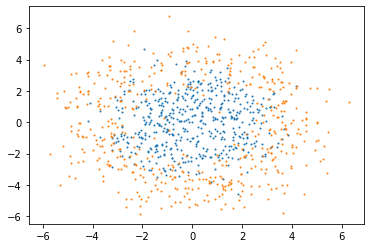

In [77]:
data0 = generateData(2,500)
data1 = generateData(4,500)
plt.figure()
plt.scatter(data0[0,:],data0[1,:], s=1)
plt.scatter(data1[0,:],data1[1,:], s=1)

In [16]:
C = 2
N = 1000

#Generates N samples from C ring-shaped 
#class-conditional pdfs with equal priors

#Randomly determine class labels for each sample
thr = np.linspace(0.0, 1.0, num=C+1) #split [0,1] into C equal length intervals
u = np.random.rand(1, N) # generate N samples uniformly random in [0,1]
labels = np.zeros((1,N))

for l in range(C):
    ind_l = np.where((thr[l]<u) & (u<=thr[l+1]))
    labels[ind_l] = np.tile(l,(1,len(ind_l[0])))

# parameters of the Gamma pdf needed later
a = [pow(i, 2.5) for i in list(range(1,C+1))]
b = np.tile(1.7, C)

#Generate data from appropriate rings
#radius is drawn from Gamma(a,b), angle is uniform in [0,2pi]
angle = 2*math.pi*u
radius = np.zeros((1,N)) # reserve space

for l in range(C):
    ind_l = np.where(labels==l)
    radius[ind_l] = np.random.gamma(a[l], b[l], len(ind_l[0]))

radius = [2, 4]
    
data = np.vstack((np.multiply(radius,np.cos(angle)), np.multiply(radius,np.sin(angle))))

colors = iter(cm.rainbow(np.linspace(0, 1, C)))
plt.figure()
for l in range(C):
    ind_l = np.where(labels==l)[1]
    plt.scatter(data[0,ind_l], data[1,ind_l], color=next(colors), s=1)

ValueError: operands could not be broadcast together with shapes (2,) (1,1000) 

In [2]:
def generateMultiringDataset(numberOfClasses,numberOfSamples):
    C = numberOfClasses
    N = numberOfSamples
    
    #Generates N samples from C ring-shaped 
    #class-conditional pdfs with equal priors
    
    #Randomly determine class labels for each sample
    thr = np.linspace(0.0, 1.0, num=C+1) #split [0,1] into C equal length intervals
    u = np.random.rand(1, N) # generate N samples uniformly random in [0,1]
    labels = np.zeros((1,N))
    
    for l in range(C):
        ind_l = np.where((thr[l]<u) & (u<=thr[l+1]))
        labels[ind_l] = np.tile(l,(1,len(ind_l[0])))
    
    # parameters of the Gamma pdf needed later
    a = [pow(i, 2.5) for i in list(range(1,C+1))]
    b = np.tile(1.7, C)
    
    #Generate data from appropriate rings
    #radius is drawn from Gamma(a,b), angle is uniform in [0,2pi]
    angle = 2*math.pi*np.random.rand(1,N)
    radius = np.zeros((1,N)) # reserve space
    
    for l in range(C):
        ind_l = np.where(labels==l)
        radius[ind_l] = np.random.gamma(a[l], b[l], len(ind_l[0]))
        
    data = np.vstack((np.multiply(radius,np.cos(angle)), np.multiply(radius,np.sin(angle))))
    
    colors = iter(cm.rainbow(np.linspace(0, 1, C)))
    plt.figure()
    for l in range(C):
        ind_l = np.where(labels==l)[1]
        plt.scatter(data[0,ind_l], data[1,ind_l], color=next(colors), s=1)
    
    return data,labels



In [3]:
def cross_validation(data, k=10, verbose=False):
    '''
    Select the best box constraint hyperparameter C and the Gaussian kernel width 
    parameter σ.  Use minimum-average-cross-validation-probability-of-error to 
    select best hyperparameters.

    Parameters
    ----------
    data: pd.DataFrame
        The data to use
    k: int, optional
        Number of folds; k-fold cross validation

    Returns
    -------
    C: float
        The C hyperparameter.
    Sigma: float
        The Gaussian kernel width parameter.
    '''
    # Make k subsamples
    cv = KFold(n_splits=k)
    # Repeat the cross-validation over numerous hyparameter configurations
    C = np.arange(0.5,10.0,0.5)
    sigmas = np.arange(0.25,10.0,0.25)
    gammas = [1/sigma for sigma in sigmas] # sigma = 1/gamma
    results = pd.DataFrame()
    X = []
    for i, row in data.iterrows():
        X.append([row['x'],row['y']])
    for c in C:
        for gamma in gammas:
            model = SVC(C=c, kernel='rbf', gamma=gamma)
            scores = cross_val_score(estimator=model, X=X, y=data['Label'], cv=cv, scoring='accuracy')
            p_errs = [1-score for score in scores]
            d = {'Mean Probability of Error Score': np.mean(p_errs), 'C': c, 'Sigma': 1/gamma, 'Gamma': gamma}
            results = results.append(d, ignore_index=True)
    data = results
    results = results.sort_values(by='Mean Probability of Error Score').iloc[0]
    min_score = results['Mean Probability of Error Score']
    if(verbose):
        print('The minimum-average-cross-validation-probability-of-error is: %.3f'%min_score)
    return results['C'], results['Gamma'], data

In [4]:
def test_hyperparameters(train_data, test_data, C, gamma):
    '''
    Train a final SVM using the best combination of hyperparameters with the entire training set. 
    Classify the testing dataset samples with this trained SVM to assess performance; estimate 
    the probability error using the test set. 

    Parameters
    ----------
    train_data: pd.DataFrame
        Data to train the model
    test_data: pd.DataFrame
        Data to test the accuracy of the model
    C: float
        The C hyperparameter.
    Sigma: float
        The Gaussian kernel width parameter.

    Returns
    -------
    test_data: pd.DataFrame
        Predicted values and original testing data.
    '''
    # Train the model using the optimized hyperparameters
    X = []
    for i, row in train_data.iterrows():
        X.append([row['x'],row['y']])
    Y = train_data['Label']
    model = SVC(C=C, kernel='rbf', gamma=gamma)
    model.fit(X,Y)
    # Test the accuracy of the model
    X = []
    for i, row in test_data.iterrows():
        X.append([row['x'],row['y']])
    Y = model.predict(X)
    test_data['Predicted Label'] = Y
    return test_data

In [5]:
def cross_validation_results(data):
    '''
    Plot how the hyperparameters change the cross validation results.

    Parameters
    ----------
    Data: pd.DataFrame
        Data on the cross validation previously done.
    
    Returns
    -------
    None
    '''
    data['Accuracy'] = 1-data['Mean Probability of Error Score']
    fig, axes = plt.subplots(1,2,sharey=True,figsize=[5,2])
    sns.regplot(data=data,x='Sigma',y='Accuracy',color='skyblue',ax=axes[0],ci=0,truncate=False,order=3,line_kws={'color':'grey'})
    sns.regplot(data=data,x='C',y='Accuracy',color='maroon',ax=axes[1],ci=0,truncate=False,order=3,line_kws={'color':'grey'})
    axes[1].set_ylabel('')
    vals = axes[0].get_yticks()
    axes[0].set_yticklabels(['{:,.0%}'.format(x) for x in vals])
    axes[0].set_xlim(0,10)
    axes[1].set_xlim(0,10)
    axes[0].set_ylim(.90,.95)
    axes[1].set_ylim(.90,.95)
    axes[0].set_xticks(np.arange(0,12,2))
    axes[0].set_xticklabels(np.arange(0,12,2))
    axes[1].set_xticks(np.arange(0,12,2))
    axes[1].set_xticklabels(np.arange(0,12,2))
    axes[1].yaxis.grid(color='lightgrey', linestyle=':')
    axes[1].xaxis.grid(color='lightgrey', linestyle=':')
    axes[1].set_axisbelow(True)
    axes[0].yaxis.grid(color='lightgrey', linestyle=':')
    axes[0].xaxis.grid(color='lightgrey', linestyle=':')
    axes[0].set_axisbelow(True)
    fig.subplots_adjust(left=0.12, right=0.965, top=.94, bottom=0.22, wspace=0.10, hspace=0.18)
    plt.savefig('./q2_cross_validation.pdf')
    plt.clf()
    plt.close()
    return None


In [6]:
def plot_model_results(data):
    '''
    Plot the accuracy of determined hyperparameters in training the model.

    Parameters
    ----------
    Data: pd.DataFrame
        Data on the model fit previously done.
    
    Returns
    -------
    None
    '''
    fig, ax = plt.subplots(1, 1, figsize=[5,4.6])
    correct = 0
    for idx,row in data.iterrows():
        true_label = row['Label']
        decision   = row['Predicted Label']
        x = row['x']
        y = row['y']
        if(true_label==1.0):
            if(true_label==decision):
                ax.plot(x,y,'go', alpha=0.1)
                correct = correct + 1
            else:
                ax.plot(x,y,'ro', alpha=0.1)
        else:
            if(true_label==decision):
                ax.plot(x,y,'g^', alpha=0.1)
                correct = correct + 1
            else:
                ax.plot(x,y,'r^', alpha=0.1)
    print('Model accuracy was %.3f'%(correct/data.shape[0]))
    ax.set_ylim(-30,30)
    ax.set_xlim(-30,30)
    ax.yaxis.grid(color='lightgrey', linestyle=':')
    ax.xaxis.grid(color='lightgrey', linestyle=':')
    ax.set_axisbelow(True)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    legend_elements = [Line2D([0], [0], marker='o', color='w', label='1', markerfacecolor='grey', markersize=15),
                        Line2D([0], [0], marker='^', color='w', label='0', markerfacecolor='grey', markersize=15)]
    legend0 = ax.legend(handles=legend_elements, title='True Class Label', loc='upper right')
    legend_elements = [Patch(facecolor='g', edgecolor='g', label='True'),
                        Patch(facecolor='r', edgecolor='r', label='False')]
    legend1 = ax.legend(handles=legend_elements, title='Correctly Classified', loc='lower right')
    ax.add_artist(legend0)
    fig.subplots_adjust(left=0.12, right=0.965, top=.96, bottom=0.10)
    plt.savefig('./q2_model_results.pdf')
    plt.clf()
    plt.close()
    return None


C:\Users\meuli\AppData\Local\Temp\ipykernel_28720\1306565658.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(d, ignore_index=True)
C:\Users\meuli\AppData\Local\Temp\ipykernel_28720\1306565658.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(d, ignore_index=True)
C:\Users\meuli\AppData\Local\Temp\ipykernel_28720\1306565658.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(d, ignore_index=True)
C:\Users\meuli\AppData\Local\Temp\ipykernel_28720\1306565658.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(d, ignore_index=True)


The minimum-average-cross-validation-probability-of-error is: 0.053
C: 2.500
Sigma: 9.750


C:\Users\meuli\AppData\Local\Temp\ipykernel_28720\4290659254.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_yticklabels(['{:,.0%}'.format(x) for x in vals])


Model accuracy was 0.926


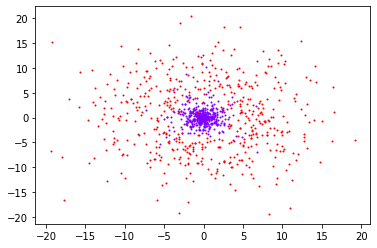

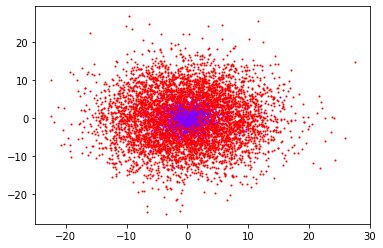

In [7]:
if __name__=='__main__':
    # Generate data and convert to pandas.DataFrame
    n_labels = 2
    N = 1000
    data, labels = generateMultiringDataset(n_labels, N)
    train = pd.DataFrame({'x': data[0], 'y': data[1], 'Label': labels[0]})
    N = 10000
    data, labels = generateMultiringDataset(n_labels, N)
    test = pd.DataFrame({'x': data[0], 'y': data[1], 'Label': labels[0]})
    # Run functions
    
    C, gamma, data = cross_validation(train, verbose=True)
    data.to_csv('./q2_cross_validation_results.csv')
    print('C: %.3f'%C)
    print('Sigma: %.3f'%(1/gamma))
    results = test_hyperparameters(train, test, C, gamma)
    results.to_csv('./q2_model_results.csv')
    
    # Plot cross validation results
    
    data = pd.read_csv('./q2_cross_validation_results.csv', index_col=0)
    cross_validation_results(data)
    
    # Plot model results
    data = pd.read_csv('./q2_model_results.csv', index_col=0)
    plot_model_results(data)